In [1]:
install.packages('xgboost')

Installing package into 'C:/Users/DELL/Documents/R/win-library/3.6'
(as 'lib' is unspecified)



package 'xgboost' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\DELL\AppData\Local\Temp\Rtmp6NBRL9\downloaded_packages


In [3]:
library(xgboost)
library(magrittr)
library(dplyr)
library(Matrix)

In [4]:
data <- read.csv('binary.csv' , header = TRUE)
head(data)
str(data)

,admit,gre,gpa,rank
,<int>,<int>,<dbl>,<int>
1,0,380,3.61,3
2,1,660,3.67,3
3,1,800,4.00,1
4,1,640,3.19,4
5,0,520,2.93,4
6,1,760,3.00,2


'data.frame':	400 obs. of  4 variables:
 $ admit: int  0 1 1 1 0 1 1 0 1 0 ...
 $ gre  : int  380 660 800 640 520 760 560 400 540 700 ...
 $ gpa  : num  3.61 3.67 4 3.19 2.93 3 2.98 3.08 3.39 3.92 ...
 $ rank : int  3 3 1 4 4 2 1 2 3 2 ...


In [64]:
data$admit <- factor(data$admit)
data$rank <- factor(data$rank)
data$admit <- as.numeric(levels(data$admit))[data$admit]
str(data)

'data.frame':	400 obs. of  4 variables:
 $ admit: num  0 1 1 1 0 1 1 0 1 0 ...
 $ gre  : int  380 660 800 640 520 760 560 400 540 700 ...
 $ gpa  : num  3.61 3.67 4 3.19 2.93 3 2.98 3.08 3.39 3.92 ...
 $ rank : Factor w/ 4 levels "1","2","3","4": 3 3 1 4 4 2 1 2 3 2 ...


In [65]:
set.seed(1234)
ind = sample(2, nrow(data) , replace = TRUE , prob = c(0.8 , 0.2))
tdata = data[ind == 1 ,]
vdata = data[ind == 2 , ]
dim(tdata)
dim(vdata)
str(tdata$admit)

[1] 325   4

[1] 75  4

 num [1:325] 0 1 1 1 1 1 0 1 0 0 ...


In [66]:
#One hot encoding
trainm <- sparse.model.matrix(admit~.-1,data = tdata)

In [67]:
head(trainm)

6 x 6 sparse Matrix of class "dgCMatrix"
  gre  gpa rank1 rank2 rank3 rank4
1 380 3.61     .     .     1     .
2 660 3.67     .     .     1     .
3 800 4.00     1     .     .     .
4 640 3.19     .     .     .     1
6 760 3.00     .     1     .     .
7 560 2.98     1     .     .     .

In [68]:
tdata_label <- tdata[,'admit']
tdata_matrix <- xgb.DMatrix(data = as.matrix(trainm) , label = tdata_label)

In [69]:
testm <- sparse.model.matrix(admit~.-1,data = vdata)
vdata_label <- vdata[,'admit']
vdata_matrix <- xgb.DMatrix(data=as.matrix(testm) , label = vdata_label)

In [70]:
#Paramters
nc <- length(unique(tdata_label))
nc

[1] 2

In [71]:
head(unique(tdata_label))

[1] 0 1

In [73]:
xgb_params <- list('objective ' = 'multi:softprob',
                   'eval_metric' = 'mlogloss',
                  'num_class' = nc)

In [74]:
watchlist <- list(train = tdata_matrix, test= vdata_matrix)

In [75]:
#Modelling
xg <- xgb.train(params = xgb_params , data = tdata_matrix , nrounds = 100 , 
               watchlist = watchlist)

[1]	train-mlogloss:0.594324	test-mlogloss:0.651085 
[2]	train-mlogloss:0.534790	test-mlogloss:0.612848 
[3]	train-mlogloss:0.483394	test-mlogloss:0.595096 
[4]	train-mlogloss:0.454567	test-mlogloss:0.597930 
[5]	train-mlogloss:0.423043	test-mlogloss:0.599238 
[6]	train-mlogloss:0.385208	test-mlogloss:0.595708 
[7]	train-mlogloss:0.372651	test-mlogloss:0.614298 
[8]	train-mlogloss:0.355396	test-mlogloss:0.612562 
[9]	train-mlogloss:0.345466	test-mlogloss:0.632218 
[10]	train-mlogloss:0.337584	test-mlogloss:0.649025 
[11]	train-mlogloss:0.321141	test-mlogloss:0.649074 
[12]	train-mlogloss:0.312773	test-mlogloss:0.664441 
[13]	train-mlogloss:0.309722	test-mlogloss:0.677517 
[14]	train-mlogloss:0.296634	test-mlogloss:0.677277 
[15]	train-mlogloss:0.284527	test-mlogloss:0.689391 
[16]	train-mlogloss:0.277117	test-mlogloss:0.684779 
[17]	train-mlogloss:0.270126	test-mlogloss:0.688089 
[18]	train-mlogloss:0.265546	test-mlogloss:0.701466 
[19]	train-mlogloss:0.260600	test-mlogloss:0.700824 
[2

In [77]:
xg

##### xgb.Booster
raw: 275.7 Kb 
call:
  xgb.train(params = xgb_params, data = tdata_matrix, nrounds = 100, 
    watchlist = watchlist)
params (as set within xgb.train):
  objective  = "multi:softprob", eval_metric = "mlogloss", num_class = "2", silent = "1"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 6 
niter: 100
nfeatures : 6 
evaluation_log:
    iter train_mlogloss test_mlogloss
       1       0.594324      0.651085
       2       0.534790      0.612848
---                                  
      99       0.083779      0.833188
     100       0.082495      0.835784

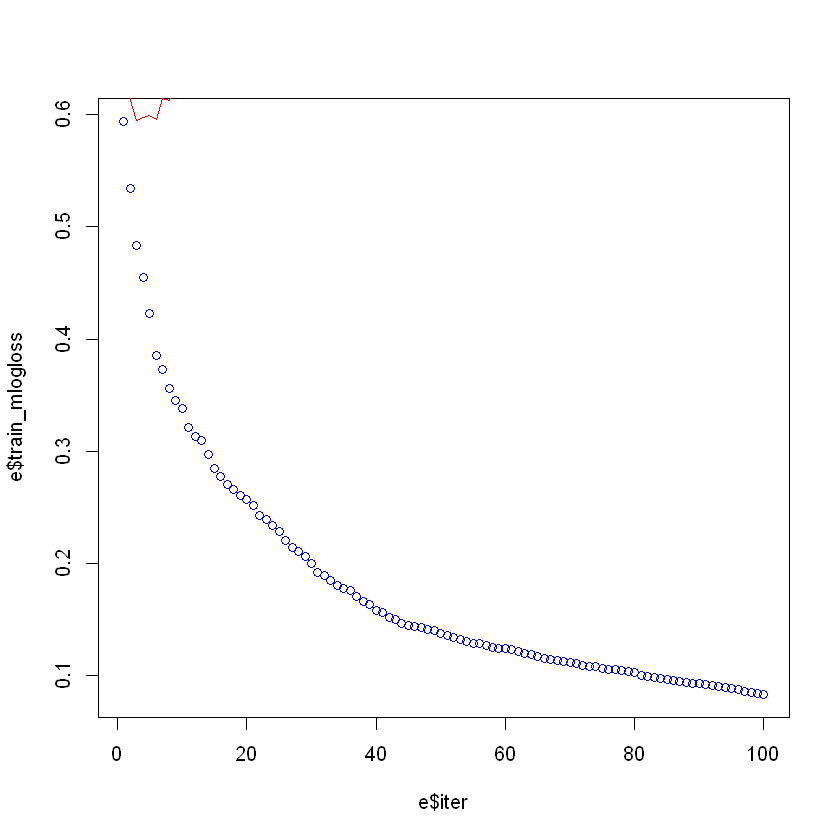

In [89]:
e <- data.frame(xg$evaluation_log)
plot(e$iter , e$train_mlogloss , col = 'blue')
lines(e$iter , e$test_mlogloss , col = 'red')

In [91]:
min(e$test_mlogloss)

[1] 0.595096

In [94]:
e[e$test_mlogloss==0.595096 , ]

,iter,train_mlogloss,test_mlogloss
,<dbl>,<dbl>,<dbl>
3,3,0.483394,0.595096


[1]	train-mlogloss:0.674595	test-mlogloss:0.684052 
[2]	train-mlogloss:0.658466	test-mlogloss:0.676982 
[3]	train-mlogloss:0.642685	test-mlogloss:0.667532 
[4]	train-mlogloss:0.628284	test-mlogloss:0.660133 
[5]	train-mlogloss:0.615050	test-mlogloss:0.653341 
[6]	train-mlogloss:0.604056	test-mlogloss:0.645568 
[7]	train-mlogloss:0.592582	test-mlogloss:0.640064 
[8]	train-mlogloss:0.582170	test-mlogloss:0.637070 
[9]	train-mlogloss:0.571289	test-mlogloss:0.634656 
[10]	train-mlogloss:0.561741	test-mlogloss:0.630253 
[11]	train-mlogloss:0.551731	test-mlogloss:0.628331 
[12]	train-mlogloss:0.542504	test-mlogloss:0.622866 
[13]	train-mlogloss:0.533755	test-mlogloss:0.618194 
[14]	train-mlogloss:0.525246	test-mlogloss:0.617723 
[15]	train-mlogloss:0.517447	test-mlogloss:0.613506 
[16]	train-mlogloss:0.509825	test-mlogloss:0.613574 
[17]	train-mlogloss:0.502859	test-mlogloss:0.609476 
[18]	train-mlogloss:0.496269	test-mlogloss:0.606218 
[19]	train-mlogloss:0.489355	test-mlogloss:0.606840 
[2

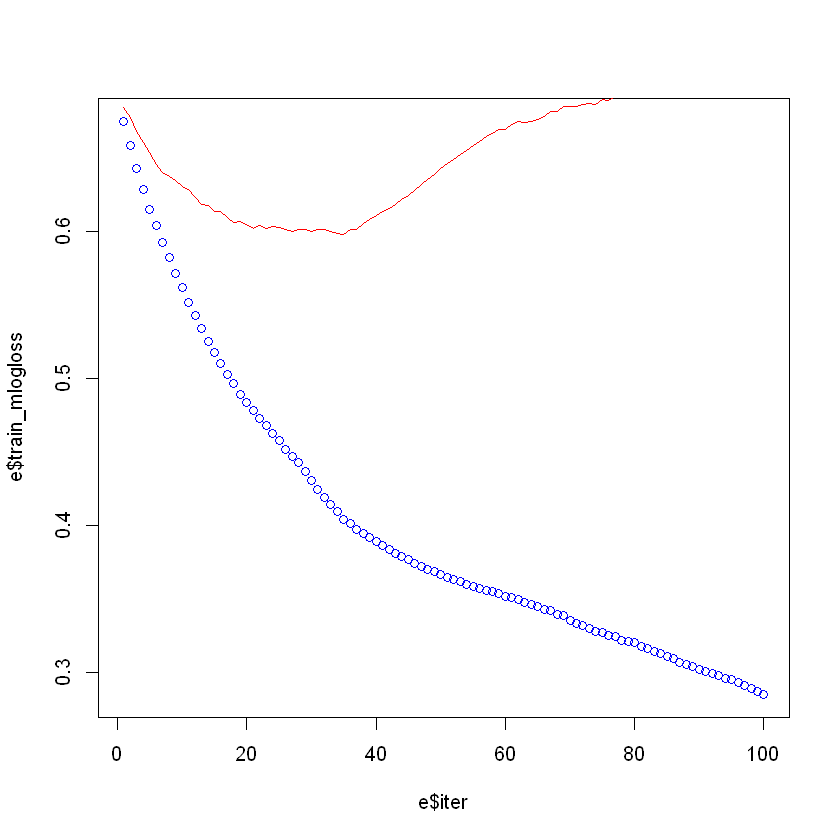

In [96]:
xg <- xgb.train(params = xgb_params , data = tdata_matrix , nrounds = 100 , 
               watchlist = watchlist,
               eta = 0.05)
e <- data.frame(xg$evaluation_log)
plot(e$iter , e$train_mlogloss , col = 'blue')
lines(e$iter , e$test_mlogloss , col = 'red')

In [98]:
#Feature importance 
imp <- xgb.importance(colnames(tdata_matrix) , model = xg)
imp

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
gpa,0.57794832,0.502489494,0.51784907
gre,0.27566043,0.327091055,0.33032083
rank1,0.07307141,0.049605539,0.04157253
rank2,0.03349270,0.040564666,0.05512878
rank4,0.02877196,0.071722378,0.04021690
rank3,0.01105517,0.008526868,0.01491188


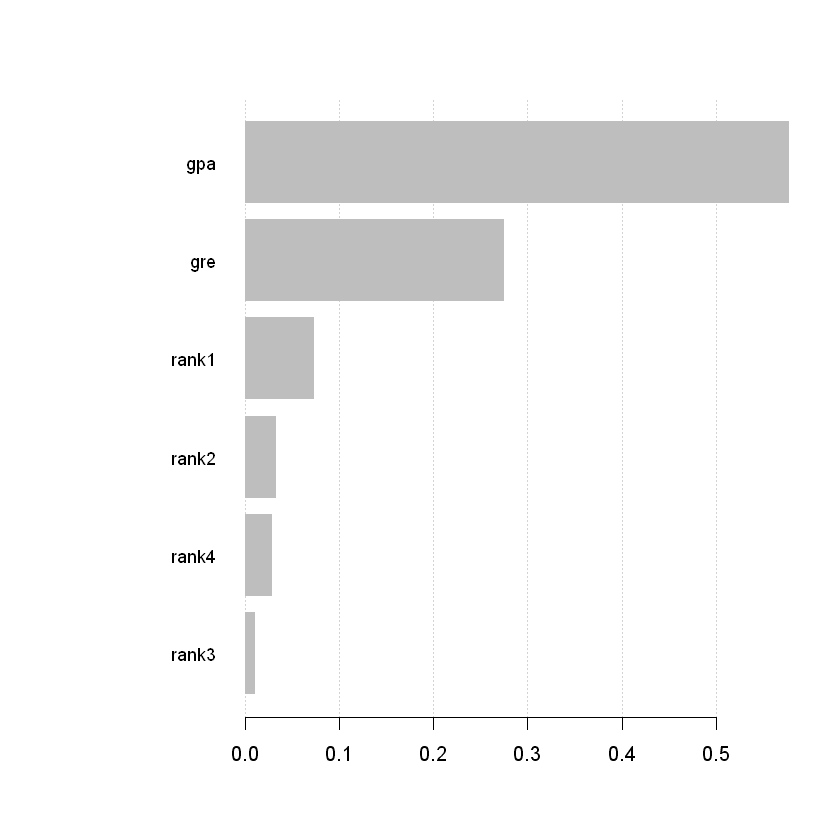

In [100]:
xgb.plot.importance(imp)

In [120]:
#Predict 
p <- predict(xg , newdata = vdata_matrix)
p

[1] 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0
[39] 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0

In [122]:
library(caret)
confusionMatrix(factor(p) , factor(vdata$admit))


Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 43 18
         1  7  7
                                          
               Accuracy : 0.6667          
                 95% CI : (0.5483, 0.7714)
    No Information Rate : 0.6667          
    P-Value [Acc > NIR] : 0.5540          
                                          
                  Kappa : 0.1573          
                                          
 Mcnemar's Test P-Value : 0.0455          
                                          
            Sensitivity : 0.8600          
            Specificity : 0.2800          
         Pos Pred Value : 0.7049          
         Neg Pred Value : 0.5000          
             Prevalence : 0.6667          
         Detection Rate : 0.5733          
   Detection Prevalence : 0.8133          
      Balanced Accuracy : 0.5700          
                                          
       'Positive' Class : 0               
                                    